In [46]:
# Import packages
import torch
from torchvision import datasets,transforms
import matplotlib.pyplot as plt
%matplotlib inline

/opt/homebrew/Caskroom/miniforge/base/envs/textscan/lib/python3.11/site-packages/torchvision/datasets/mnist.py:53: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")
/opt/homebrew/Caskroom/miniforge/base/envs/textscan/lib/python3.11/site-packages/torchvision/datasets/mnist.py:43: UserWarning: train_labels has been renamed targets
  warnings.warn("train_labels has been renamed targets")


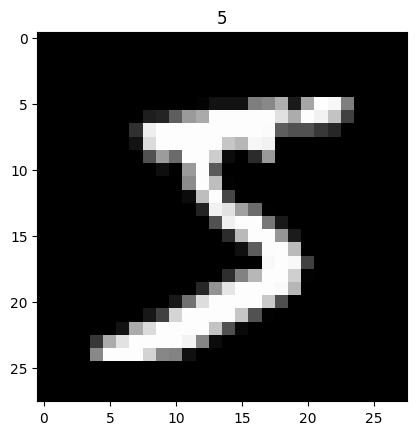

In [47]:
# Download MNIST dataset and plot one image

# Download the training data
trainset = datasets.MNIST('MNIST_data/', download=False, train=True, transform=transforms.ToTensor())

# Download the test data
testset = datasets.MNIST('MNIST_data/', download=False, train=False, transform=transforms.ToTensor())

# Plot one image

plt.imshow(trainset.train_data[0].numpy(), cmap='gray')
plt.title('%i' % trainset.train_labels[0])
plt.show()


In [48]:
# Import some libraries for implementing the diffusion model
from IPython.display import Image
import math
from inspect import isfunction # to check if a variable is a function
from functools import partial # to create a function with some fixed arguments
from tqdm.auto import tqdm # to display a progress bar
from einops import rearrange # to reshape tensors

import torch
from torch import nn, einsum 
import torch.nn.functional as F

In [49]:
# Let us write some helper functions

# function to check if a function exists
def exists(x):
    return x is not None

# function to check if a variable is a list
def default(val,d): 
    if exists(val):
        return val
    return d() if isfunction(d) else d # if d is a function, call it, otherwise return it

class Residual(nn.Module): # Residual block
    def __init__(self,fn): # fn is the function to be applied
        super().__init__()
        self.fn = fn
    
    def forward(self, x, *args, **kwargs):
        return self.fn(x,*args,**kwargs) + x # add the input to the output of the function
    
def Upsample(dim): # upsampling image representation function
    return nn.ConvTranspose2d(dim,dim,4,2,1) # 2D transposed convolution with stride 2 and padding 1 and kernel size 4

def Downsample(dim): # scaling down an image to its lower level representation
    return nn.Conv2d(dim,dim,4,2,1) # 2D convolution with stride 2 and padding 1 and kernel size 4



It is important to note here that the same model weights are shared across the 'timesteps' or iterations of the diffusion process.

In order to keep track of the timesteps, the authors of Diffusion model used some form of time embedding. This has been originally done using a sinusoidal positional embedding. Quite frankly, time, position and iteration are used quite freely in literature.

What is important to note is that with each forward step in time/position/iteration, noise is either added or removed.

In [50]:
# Let us implement this sinusoidal positional encoding function

class SinusoidalPositionalEmbeddings(nn.Module):
    def __init__(self,dim):
        super().__init__()
        self.dim = dim
        
    
    def forward(self,time):
        device = time.device
        half_dim = self.dim // 2
        embeddings = math.log(10000) / (half_dim - 1) # apply log to the time dimension
        embeddings = torch.exp(torch.arange(half_dim, device = device) * -embeddings) # apply exponential 
        embeddings = time[:,None] * embeddings[None,:]
        embeddings = torch.cat([embeddings.sin(), embeddings.cos()], dim = -1)
        return embeddings

# Test the above function
SinusoidalPositionalEmbeddings(8)(torch.arange(4.0)).shape

# This takes a 1D tensor of time and returns a 2D tensor of embeddings of shape (time, dim)



torch.Size([4, 8])

In [51]:
# We will now begin implementing the Unet architecture that is native to the Denoising Diffusion Probabilistic Model

# We will use both the ResNet and the ConvNext architectures so that a choice can be made later

class Block(nn.Module):
    def __init__(self,dim,dim_out,groups = 8):
        super().__init__()
        self.proj = nn.Conv2d(dim,dim_out,3,padding=1)
        self.norm = nn.GroupNorm(groups,dim_out) # group norm computes the mean and standard deviation across both batch and channels
        self.act  = nn.SELU() # scaled exponential linear unit

    def forward(self,x,scale_shift=None):
        x = self.proj(x)
        x = self.norm(x)

        if exists(scale_shift):
            scale,shift = scale_shift
            x = (scale+1) * x + shift
        
        x = self.act(x)
        return x

# Let us test the above function

Block(8,8)(torch.randn(1,8,4,4)).shape    

# Block returns a tensor of the same size as the input

torch.Size([1, 8, 4, 4])

In [52]:


class ResnetBlock(nn.Module):
    """https://arxiv.org/abs/1512.03385"""

    def __init__(self, dim, dim_out, *, time_emb_dim = None, groups=8):
        super().__init__()
        self.mlp = (
            nn.Sequential(nn.SiLU,nn.Linear(time_emb_dim, dim_out ))
            if exists(time_emb_dim) 
            else None

        )
        self.block1 = Block(dim,dim_out,groups=groups)
        self.block2 = Block(dim_out,dim_out,groups=groups)
        self.res_conv = nn.Conv2d(dim,dim_out,1) if dim != dim_out else nn.Identity() 

    def forward(self,x,time_emb=None):
        h = self.block1(x)

        if exists(self.mlp) and exists(time_emb):
            time_emb = self.mlp(time_emb)
            h = rearrange(time_emb, "b c -> b c 1 1") + h
        
        h = self.block2(h)

        return self.res_conv(x) + h

# Let us test the above function

ResnetBlock(8,8)(torch.randn(1,8,4,4)).shape

# ResnetBlock returns a tensor of the same size as the input


torch.Size([1, 8, 4, 4])

In [53]:
class ConvNextBlock(nn.Module):
    """https://arxiv.org/abs/2201.03545"""

    def __init__(self, dim, dim_out, *, time_emb_dim=None, mult=2, norm=True):
        super().__init__()
        self.mlp = (
            nn.Sequential(nn.GELU(), nn.Linear(time_emb_dim, dim))
            if exists(time_emb_dim)
            else None
        )

        self.ds_conv = nn.Conv2d(dim, dim, 7, padding=3, groups=dim)

        self.net = nn.Sequential(
            nn.GroupNorm(1, dim) if norm else nn.Identity(),
            nn.Conv2d(dim, dim_out * mult, 3, padding=1),
            nn.GELU(),
            nn.GroupNorm(1, dim_out * mult),
            nn.Conv2d(dim_out * mult, dim_out, 3, padding=1),
        )

        self.res_conv = nn.Conv2d(dim, dim_out, 1) if dim != dim_out else nn.Identity()

    def forward(self, x, time_emb=None):
        h = self.ds_conv(x)

        if exists(self.mlp) and exists(time_emb):
            condition = self.mlp(time_emb)
            h = h + rearrange(condition, "b c -> b c 1 1")

        h = self.net(h)
        return h + self.res_conv(x)


In [54]:
# We will, in the following, implement an attention module of the Vaswani et al. type as well as 
# the Linear attention module of the Diffusion Probabilistic Model

class Attention(nn.Module):
    def __init__(self, dim, heads = 4, dim_head = 32):
        super().__init__()
        self.scale = dim_head**-0.5 # for scaling the attention weights
        self.heads = heads
        hidden_dim = dim_head * heads
        self.to_qkv = nn.Conv2d(dim,hidden_dim * 3, 1, bias=False)
        self.to_out = nn.Conv2d(hidden_dim,dim,1)
    
    def forward(self,x):
        b, c, h, w = x.shape
        qkv = self.to_qkv(x).chunk(3,dim=1) # split the input into query, key and value
        q, k, v = map(
            lambda t: rearrange(t, "b (h c) x y -> b h c (x y)", h = self.heads), qkv
        )
        q = q * self.scale # scale the query

        print(q.shape, k.shape)

        sim = einsum("b h d i, b h d j -> b h i j",q, k)
        sim = sim - sim.amax(dim=-1, keepdim=True).detach()
        attn = sim.softmax(dim = -1)

        out = einsum("b h i j, b h d j -> b h d i",attn, v)
        out = rearrange(out, "b h (x y) d -> b (h d) x y", x = h, y = w)
        return self.to_out(out)

# Let us test the above function

Attention(3)(torch.randn(1,3,4,8)).shape


torch.Size([1, 4, 32, 32]) torch.Size([1, 4, 32, 32])


torch.Size([1, 3, 4, 8])

In [55]:
    
# Now implement the Linear Attention module

class LinearAttention(nn.Module):
    def __init__(self,dim,heads=4,dim_heads=32):
        super().__init__()
        self.scale = dim_heads**-0.5
        self.heads = heads
        hidden_dim = dim_heads * heads
        self.to_qkv = nn.Conv2d(dim, hidden_dim*3, 1, bias=False)
        self.to_out = nn.Sequential(nn.Conv2d(hidden_dim,dim,1),
                                    nn.GroupNorm(1,dim)
                                    )
        
    def forward(self,x):
        b, c, h, w = x.shape
        qkv = self.to_qkv(x).chunk(3,dim=1)
        q, k, v = map(
            lambda t: rearrange(t, "b (h c) x y -> b h c (x y)", h = self.heads), qkv
        )

        q = q.softmax(dim=-2)
        k = k.softmax(dim=-1)

        q = q * self.scale
        context = torch.einsum("b h d n, b h e n -> b h d e", k, v)

        out = torch.einsum("b h d e, b h d n -> b h e n", context, q)
        out = rearrange(out,"b h c (x y)-> b (h c) x y", h = self.heads, x = h, y = w)
        return self.to_out(out)


In [56]:
class ConvNextBlock(nn.Module):
    """https://arxiv.org/abs/2201.03545"""

    def __init__(self, dim, dim_out, *, time_emb_dim=None, mult=2, norm=True):
        super().__init__()
        self.mlp = (
            nn.Sequential(nn.GELU(), nn.Linear(time_emb_dim, dim))
            if exists(time_emb_dim)
            else None
        )

        self.ds_conv = nn.Conv2d(dim, dim, 7, padding=3, groups=dim)

        self.net = nn.Sequential(
            nn.GroupNorm(1, dim) if norm else nn.Identity(),
            nn.Conv2d(dim, dim_out * mult, 3, padding=1),
            nn.GELU(),
            nn.GroupNorm(1, dim_out * mult),
            nn.Conv2d(dim_out * mult, dim_out, 3, padding=1),
        )

        self.res_conv = nn.Conv2d(dim, dim_out, 1) if dim != dim_out else nn.Identity()

    def forward(self, x, time_emb=None):
        h = self.ds_conv(x)

        if exists(self.mlp) and exists(time_emb):
            condition = self.mlp(time_emb)
            h = h + rearrange(condition, "b c -> b c 1 1")

        h = self.net(h)
        return h + self.res_conv(x)

In [57]:

# In DDPM, a groupnorm is used after the attention/convolutional layers of the U-Net.

# We can create a prenorm layer to add a normalization before the attention operation

class PreNorm(nn.Module):
    def __init__(self,dim,fn):
        super().__init__()
        self.norm = nn.GroupNorm(1,dim)
        self.fn = fn
    
    def forward(self,x):
        return self.fn(self.norm(x))


We have now constructed all the modules we need for assembling the UNet model. 

The idea here is to take a batch of images of dimension (batch_size, num_channels, height, width) and a batch of noise levels of size (batch)size, 1), as input and return a tensor of shape (batch_size, num_channels, height, width)

Here, the network takes the images and the noise levels, and output the noise added to the input

The network goes as follows:
1. a convolution is first applied to the batch of images, and position embeddings are computed for each noise level.
2. a sequence of downsampling steps are performed, where:
    each downsampling contains: two resnt/convnext blocks, group norm, attention, residual connection, and a downsampling operation.
3. in between the downsampling, a ResNet or ConvNext block are added, and attention is added again.
4. Following the downsampling, the upsampling steps are performed. This contains:
    two resnet/convnext blocks, group norm, attention, residual connection, and upsample operation.
5. finally, a resnet/convnext block followed by a convolution is added.

In [58]:
nn.Conv2d(3, 32//3 *2, 7, padding=3)

image_size = 32
dim=image_size
init_dim = dim//3 *2#default(None, dim//3 *2)
channels=3
dim_mults=(1, 2, 4,)

dims = [init_dim, *map(lambda m: dim * m, dim_mults)]

in_out = list(zip(dims[:-1],dims[1:]))
# Pretend we use convnext
convnext_mult = 2
block_klass = partial(ConvNextBlock, mult = convnext_mult) # basically it is ConvNextBlock, but with mult argument frozen to 2

# Pretend with time emb is tru

time_dim = dim * 4
time_mlp = nn.Sequential(
    SinusoidalPositionalEmbeddings(dim),
    nn.Linear(dim,time_dim),
    nn.GELU(),
    nn.Linear(time_dim,time_dim),
)

batch_size = 128
timesteps  =200
t = torch.randint(0, timesteps, (batch_size,))
time_emb = time_mlp(t) # Found out the issue. I had forgotten to uncomment last two lines in SinusoidalPositionalEmbeddings

In [59]:

# Let us now implement the U-Net architecture

class UNet(nn.Module):
    def __init__(self, dim, init_dim = None, out_dim = None, dim_mults = (1,2,4,8), channels=3, with_time_emb = True,
                 resnet_block_groups = 8, use_convnext=True, convnext_mult = 2):
        
        super().__init__()
        self.channels = channels # 3 channels
        init_dim = default(init_dim, dim//3 *2) # init_dim is None. So default value is dim//3 *2, which is 32//3 *2 = 20 for image size 32
        self.init_conv = nn.Conv2d(channels, init_dim, 7, padding=3) # 3 input channels, 20 output channels, 7x7 kernel, padding = 3
        dims = [init_dim, *map(lambda m: dim * m, dim_mults)] # [20, 32*1, 32*2, 32*4] = [20, 32, 64, 128] for dim_mults = (1,2,4)
        in_out = list(zip(dims[:-1],dims[1:])) # groups dims to [(20, 32), (32, 64), (64, 128)], representing in and out sizes of each block

        if use_convnext:
            block_klass = partial(ConvNextBlock, mult = convnext_mult) # Freeze mult to 2 for ConvNextBlock
        else:
            block_klass = partial(ResnetBlock,groups=resnet_block_groups)
        
        # time embedding
        if with_time_emb:
            time_dim = dim * 4 # for dim 32, 32 * 4 = 128
            self.time_mlp = nn.Sequential(
                SinusoidalPositionalEmbeddings(dim), # dim = 32, so it returns a tensor of size 1
                nn.Linear(dim,time_dim),
                nn.GELU(),
                nn.Linear(time_dim,time_dim),
            )
        else:
            time_dim = None
            self.time_mlp = None
        
        # layers
        self.downs = nn.ModuleList([])
        self.ups = nn.ModuleList([])
        num_resolution = len(in_out)

        for ind, (dim_in,dim_out) in enumerate(in_out):
            is_last = ind >= (num_resolution-1)
            self.downs.append(
                nn.ModuleList(
                    [
                        block_klass(dim_in,dim_out, time_emb_dim = time_dim),
                        block_klass(dim_out,dim_out, time_emb_dim = time_dim),
                        Residual(PreNorm(dim_out, LinearAttention(dim_out))),
                        Downsample(dim_out) if not is_last else nn.Identity()

                    ]
                )

            )
        
        mid_dim = dims[-1]
        self.mid_block1 = block_klass(mid_dim,mid_dim, time_emb_dim = time_dim)
        self.mid_attn   = Residual(PreNorm(mid_dim, LinearAttention(mid_dim)))
        self.mid_block2 = block_klass(mid_dim,mid_dim, time_emb_dim = time_dim)

        for ind, (dim_in,dim_out) in enumerate(reversed(in_out[1:])):
            is_last = ind>=(num_resolution-1)

            self.ups.append(
                nn.ModuleList(
                    [
                        block_klass(dim_out*2,dim_in, time_emb_dim = time_dim),
                        block_klass(dim_in,dim_in, time_emb_dim = time_dim),
                        Residual(PreNorm(dim_in, LinearAttention(dim_in))),
                        Upsample(dim_in) if not is_last else nn.Identity(),
                    ]
                )
            )
        
        out_dim = default(out_dim, channels)
        self.final_conv = nn.Sequential(block_klass(dim,dim), nn.Conv2d(dim, out_dim, 1))

    def forward(self,x, time):

        x = self.init_conv(x)

        t = self.time_mlp(time) if exists (self.time_mlp) else None

        h = []

        # downsample
        for block1, block2, attn, downsample in self.downs:
            x = block1(x, t)
            x = block2(x, t)
            x = attn(x)
            h.append(x)
            x = downsample(x)

        # middle
        x = self.mid_block1(x, t)
        x = self.mid_attn(x)
        x = self.mid_block2(x, t)

        # upsample
        for block1, block2, attn, upsample in self.ups:
            x = torch.cat((x,h.pop()), dim=1)
            x = block1(x, t)
            x = block2(x, t)
            x = attn(x)
            x = upsample(x)
        
        return self.final_conv(x)

# Note: by default, the noise predictor uses ConvNeXT blocks 
# (as use_convnext is set to True) and position embeddings are added (as with_time_emb is set to True).



We will now also add the forward diffusion process where you add noise in timesteps t. This is done in a number of schedule types, all of which will be implemented in the following.

In [60]:
# linear beta scheduler
def linear_beta_schedule(timesteps):
    beta_start = 0.0001
    beta_end = 0.02
    return torch.linspace(beta_start, beta_end, timesteps)

# quadradic beta scheduler
def quadratic_beta_schedule(timesteps):
    beta_start = 0.0001
    beta_end = 0.02
    return torch.sqrt(torch.linspace(beta_start**0.5, beta_end**0.5, timesteps)) ** 2

# sigmoid beta scheduler
def sigmoid_beta_schedule(timesteps):
    beta_start = 0.0001
    beta_end = 0.02
    return torch.sigmoid(torch.linspace(-5, 5, timesteps)) * (beta_end - beta_start) + beta_start

# cosine beta scheduler, from https://arxiv.org/abs/2102.09672
def cosine_beta_schedule(timesteps, s=0.008):
    steps = timesteps + 1
    x = torch.linspace(0,timesteps,steps)
    alphas_cumprod = torch.cos(((x + timesteps) + s)/(1 + s) * torch.pi * 0.5) ** 2
    alphas_cumprod = alphas_cumprod / alphas_cumprod[0]
    betas = 1 - (alphas_cumprod[1:] / alphas_cumprod[:-1])
    return torch.clip(betas, 0.0001, 0.999)




In [61]:
# Let us take the forward diffusion out for a spin
timesteps = 200
betas = linear_beta_schedule(timesteps = timesteps)

# define alphas
alphas = 1. - betas
alphas_cumprod = torch.cumprod(alphas, dim=0)
alphas_cumprod_prev = F.pad(alphas_cumprod[:-1],(1,0),value=1.)
sqrt_recip_alphas = torch.sqrt(1.0 / alphas)

# Calculations for diffusion q(x_t | x_t-1) and others
sqrt_alphas_cumprod = torch.sqrt(alphas_cumprod)
sqrt_one_minus_alphas_cumprod = torch.sqrt(1 - alphas_cumprod)

# calculations for posterior q(x_t-1 | x_t, x_0)
posteriori_variance = betas * (1 - alphas_cumprod_prev) / (1. - alphas_cumprod)

def extract(a,t,x_shape):
    batch_size = t.shape[0]
    out = a.gather(-1,t.cpu())
    return out.reshape(batch_size, *((1,)*(len(x_shape) -1))).to(t.device)



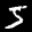

In [62]:
# now let us apply it
from PIL import Image
from torchvision.transforms import Compose, ToTensor, Lambda, ToPILImage, CenterCrop, Resize

image = trainset.train_data[0].numpy()

image_size = 32
transform = Compose([
    transforms.ToPILImage(),
    Resize(image_size),
    ToTensor(),
    Lambda(lambda t: (t * 2 )- 1),
])

x_start = transform(image).unsqueeze(0)

import numpy as np

reverse_transform = Compose([
    Lambda(lambda t: (t+1) / 2),
    Lambda(lambda t: t.permute(1,2,0)),
    Lambda(lambda t: t*255.),
    Lambda(lambda t: t.numpy().astype(np.uint8)),
    ToPILImage(),
])

reverse_transform( x_start.repeat(1, 3, 1, 1).squeeze(0))

In [63]:
# Let us now implement the forward diffusion model

def q_sample(x_start, t, noise=None):
    if noise is None:
        noise = torch.randn_like(x_start)

    sqrt_alphas_cumprod_t = extract(sqrt_alphas_cumprod, t, x_start.shape)
    sqrt_one_minus_alphas_cumprod_t = extract(
        sqrt_one_minus_alphas_cumprod, t, x_start.shape
    )

    return sqrt_alphas_cumprod_t * x_start + sqrt_one_minus_alphas_cumprod_t * noise
def get_noisy_image(x_start,t):
    x_noisy = q_sample(x_start, t=t)
    noisy_image = reverse_transform(x_noisy.repeat(1, 3, 1, 1).squeeze())

    return noisy_image


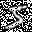

In [64]:
# test the noise addition
t = torch.tensor([10])
get_noisy_image(x_start, t)

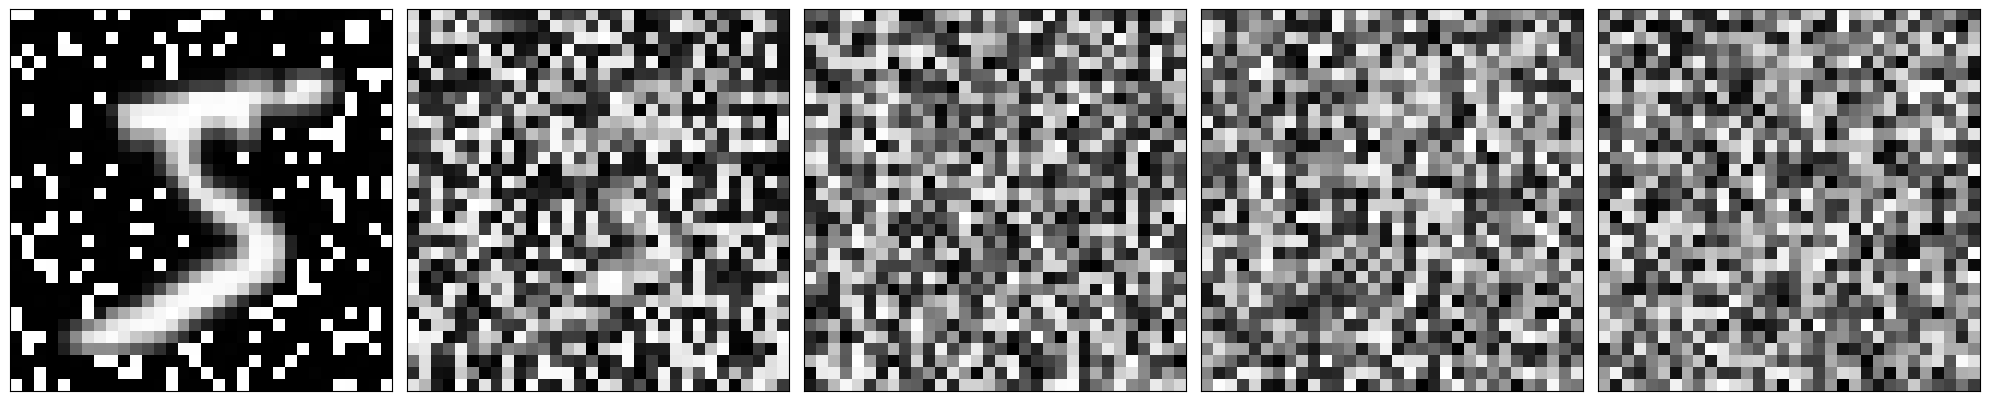

In [65]:
# visualize it for a sequence of timesteps

torch.manual_seed(0)

def plot(imgs, with_orig=False, row_title=None, **imshow_kwargs):
    if not isinstance(imgs[0], list):
        # Make a 2d grid even if there's just 1 row
        imgs = [imgs]

    num_rows = len(imgs)
    num_cols = len(imgs[0]) + with_orig
    fig, axs = plt.subplots(figsize=(20,20), nrows=num_rows, ncols=num_cols, squeeze=False)
    for row_idx, row in enumerate(imgs):
        row = [image] + row if with_orig else row
        for col_idx, img in enumerate(row):
            ax = axs[row_idx, col_idx]
            ax.imshow(np.asarray(img), **imshow_kwargs)
            ax.set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

    if with_orig:
        axs[0, 0].set(title='Original image')
        axs[0, 0].title.set_size(8)
    if row_title is not None:
        for row_idx in range(num_rows):
            axs[row_idx, 0].set(ylabel=row_title[row_idx])

    plt.tight_layout()

plot([get_noisy_image(x_start, torch.tensor([t])) for t in [0, 50, 100, 150, 199]])

In [66]:
# Thus, we can now move on to defining our loss function. 
# The denoise_model will be our U-Net defined above. We’ll employ the Huber loss between the true and the predicted noise.

def p_losses(denoise_model, x_start, t, noise=None, loss_type="l1"):
    if noise is None:
        noise = torch.randn_like(x_start)

    x_noisy = q_sample(x_start=x_start, t=t, noise=noise)
    predicted_noise = denoise_model(x_noisy, t)

    if loss_type == 'l1':
        loss = F.l1_loss(noise, predicted_noise)
    elif loss_type == 'l2':
        loss = F.mse_loss(noise, predicted_noise)
    elif loss_type == "huber":
        loss = F.smooth_l1_loss(noise, predicted_noise)
    else:
        raise NotImplementedError()

    return loss

In [67]:
from datasets import load_dataset

# load dataset from the hub
dataset = load_dataset("fashion_mnist")
image_size = 28
channels = 1
batch_size = 128

Found cached dataset fashion_mnist (/Users/swarajnanda/.cache/huggingface/datasets/fashion_mnist/fashion_mnist/1.0.0/8d6c32399aa01613d96e2cbc9b13638f359ef62bb33612b077b4c247f6ef99c1)


  0%|          | 0/2 [00:00<?, ?it/s]

In [68]:
from torchvision import transforms
from torch.utils.data import DataLoader

# define image transformations (e.g. using torchvision)
transform = Compose([
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            transforms.Lambda(lambda t: (t * 2) - 1)
])

# define function
def transforms(examples):
   examples["pixel_values"] = [transform(image.convert("L")) for image in examples["image"]]
   del examples["image"]

   return examples

transformed_dataset = dataset.with_transform(transforms).remove_columns("label")

# create dataloader
dataloader = DataLoader(transformed_dataset["train"], batch_size=batch_size, shuffle=True)


In [69]:
batch = next(iter(dataloader))
print(batch.keys())

dict_keys(['pixel_values'])


Sampling During Training
The paper also talks about sampling from the model during training in order to track progress.
Ideally, generating new images from a diffusion model happens by reversing the diffusion process:
    We start from T, where we sample pure noise from a Gaussian distribution

    Then use our neural network to gradually de-noise it using the conditional probability it has learned, continuing until we end up at time step t = 0.
    
    We can derive a slightly less de-noised image x(t−1) by plugging in the re-parametrization of the mean, using our noise predictor.
    
    Remember that the variance is known ahead of time.

After all of this, ideally, we end up with an image that looks like it came from the real data distribution.
Lets look at the code for that below:

In [70]:
@torch.no_grad()
def p_sample(model, x, t, t_index):
    betas_t = extract(betas, t, x.shape)
    sqrt_one_minus_alphas_cumprod_t = extract(
        sqrt_one_minus_alphas_cumprod, t, x.shape
    )
    sqrt_recip_alphas_t = extract(sqrt_recip_alphas, t, x.shape)
    
    # Equation 11 in the paper
    # Use our model (noise predictor) to predict the mean
    model_mean = sqrt_recip_alphas_t * (
        x - betas_t * model(x, t) / sqrt_one_minus_alphas_cumprod_t
    )

    if t_index == 0:
        return model_mean
    else:
        posterior_variance_t = extract(posteriori_variance, t, x.shape)
        noise = torch.randn_like(x)
        # Algorithm 2 line 4:
        return model_mean + torch.sqrt(posterior_variance_t) * noise 

# Algorithm 2 (including returning all images)
@torch.no_grad()
def p_sample_loop(model, shape):
    device = next(model.parameters()).device

    b = shape[0]
    # start from pure noise (for each example in the batch)
    img = torch.randn(shape, device=device)
    imgs = []

    for i in tqdm(reversed(range(0, timesteps)), desc='sampling loop time step', total=timesteps):
        img = p_sample(model, img, torch.full((b,), i, device=device, dtype=torch.long), i)
        imgs.append(img.cpu().numpy())
    return imgs

@torch.no_grad()
def sample(model, image_size, batch_size=16, channels=3):
    return p_sample_loop(model, shape=(batch_size, channels, image_size, image_size))

Now, lets get to some training! We will train the model via PyTorch and occasionally save a few image samples using the sample function from above.

In [71]:
from pathlib import Path

def num_to_groups(num, divisor):
    groups = num // divisor
    remainder = num % divisor
    arr = [divisor] * groups
    if remainder > 0:
        arr.append(remainder)
    return arr

results_folder = Path("./results")
results_folder.mkdir(exist_ok = True)
save_and_sample_every = 1000

In [72]:
from torch.optim import Adam

device = "mps" #if torch.cuda.is_available() else "cpu"

model = UNet(
    dim=image_size,
    channels=channels,
    dim_mults=(1, 2, 4,)
)
model.to(device)

optimizer = Adam(model.parameters(), lr=1e-3)

# find number of parameters in model
num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Number of parameters: {num_params}")

Number of parameters: 2996539


In [73]:
# Train the model

from torchvision.utils import save_image

epochs = 5

for epoch in range(epochs):
    for step, batch in enumerate(dataloader):
      optimizer.zero_grad()

      batch_size = batch["pixel_values"].shape[0]
      batch = batch["pixel_values"].to(device)

      # Algorithm 1 line 3: sample t uniformally for every example in the batch
      t = torch.randint(0, timesteps, (batch_size,), device=device).long()

      loss = p_losses(model, batch, t, loss_type="huber")

      if step % 100 == 0:
        print("Loss:", loss.item())

      loss.backward()
      optimizer.step()

      # save generated images
      if step != 0 and step % save_and_sample_every == 0:
        milestone = step // save_and_sample_every
        batches = num_to_groups(4, batch_size)
        all_images_list = list(map(lambda n: sample(model, batch_size=n, channels=channels), batches))
        all_images = torch.cat(all_images_list, dim=0)
        all_images = (all_images + 1) * 0.5
        save_image(all_images, str(results_folder / f'sample-{milestone}.png'), nrow = 6)



Loss: 0.4693230390548706


NotImplementedError: The operator 'aten::native_group_norm_backward' is not currently implemented for the MPS device. If you want this op to be added in priority during the prototype phase of this feature, please comment on https://github.com/pytorch/pytorch/issues/77764. As a temporary fix, you can set the environment variable `PYTORCH_ENABLE_MPS_FALLBACK=1` to use the CPU as a fallback for this op. WARNING: this will be slower than running natively on MPS.